In [560]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from math import ceil, floor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from collections import defaultdict
from tqdm.auto import tqdm

import random
from sklearn.ensemble import RandomForestClassifier

import pandas_profiling
import warnings

from collections import Counter

import geopandas as gpd

from pylab import *

In [33]:
map_dict = {'"JET"': {'all': 3144,
  'lat': '51.652',
  'lon': '-1.266',
  'jet': 1,
  'tar': 3144},
 '"Max Planck"': {'all': 1263,
  'lat': '48.141111',
  'lon': '11.582222',
  'jet': 0,
  'tar': 2500},
 '"MIT"': {'all': 86, 'lat': '42.36', 'lon': '-71.092', 'jet': 0, 'tar': 750},
 '"San Diego"': {'all': 493,
  'lat': '32.893461',
  'lon': '-117.234556',
  'jet': 0,
  'tar': 1250},
 '"Naka"': {'all': 619,
  'lat': '36.442694',
  'lon': '140.595861',
  'jet': 0,
  'tar': 1250},
 '"Switzerland"': {'all': 21,
  'lat': '46.520278',
  'lon': '6.565556',
  'jet': 0,
  'tar': 100},
 '"Montreal"': {'all': 10,
  'lat': '45.508889',
  'lon': '-73.561667',
  'jet': 0,
  'tar': 75},
 '"PPPL"': {'all': 518,
  'lat': '40.348825',
  'lon': '-74.602183',
  'jet': 0,
  'tar': 1550}}

In [34]:
df = pd.DataFrame(map_dict)
df.columns = list(map(lambda name: name.replace('"', ""),df.columns))
df = pd.DataFrame.transpose(df)
df

,all,lat,lon,jet,tar
JET,3144,51.652,-1.266,1,3144
Max Planck,1263,48.141111,11.582222,0,2500
MIT,86,42.36,-71.092,0,750
San Diego,493,32.893461,-117.234556,0,1250
Naka,619,36.442694,140.595861,0,1250
Switzerland,21,46.520278,6.565556,0,100
Montreal,10,45.508889,-73.561667,0,75
PPPL,518,40.348825,-74.602183,0,1550


['europe',
 'europe',
 'america',
 'america',
 'japan',
 'europe',
 'america',
 'america']

In [245]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(list(map(float,df.lon)), list(map(float,df.lat)))
)

gdf.drop(columns=["lat", "lon"], inplace=True)

gdf["continent"] = """
europe
europe
america
america
japan
europe
america
america
""".split()

gdf

,all,jet,tar,geometry,continent
JET,3144,1,3144,POINT (-1.26600 51.65200),europe
Max Planck,1263,0,2500,POINT (11.58222 48.14111),europe
MIT,86,0,750,POINT (-71.09200 42.36000),america
San Diego,493,0,1250,POINT (-117.23456 32.89346),america
Naka,619,0,1250,POINT (140.59586 36.44269),japan
Switzerland,21,0,100,POINT (6.56556 46.52028),europe
Montreal,10,0,75,POINT (-73.56167 45.50889),america
PPPL,518,0,1550,POINT (-74.60218 40.34882),america


In [277]:
americas = world[world.continent == "North America"]
europa = world[world.continent == "Europe"]
# europa = europa[europa.centroid.x < 50]
europa = europa[europa.centroid.x > -10]
japan = world[world.name == "Japan"]


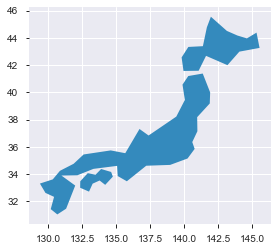

JET             europe
Max Planck      europe
MIT            america
San Diego      america
Naka             japan
Switzerland     europe
Montreal       america
PPPL           america
Name: continent, dtype: object

In [230]:
americas

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
16,10646714,North America,Haiti,HTI,19340.0,"POLYGON ((-71.71236 19.71446, -71.62487 19.169..."
17,10734247,North America,Dominican Rep.,DOM,161900.0,"POLYGON ((-71.70830 18.04500, -71.68774 18.316..."
19,329988,North America,Bahamas,BHS,9066.0,"MULTIPOLYGON (((-78.98000 26.79000, -78.51000 ..."
22,57713,North America,Greenland,GRL,2173.0,"POLYGON ((-46.76379 82.62796, -43.40644 83.225..."
27,124574795,North America,Mexico,MEX,2307000.0,"POLYGON ((-117.12776 32.53534, -115.99135 32.6..."
33,3753142,North America,Panama,PAN,93120.0,"POLYGON ((-77.35336 8.67050, -77.47472 8.52429..."
34,4930258,North America,Costa Rica,CRI,79260.0,"POLYGON ((-82.54620 9.56613, -82.93289 9.47681..."
35,6025951,North America,Nicaragua,NIC,33550.0,"POLYGON ((-83.65561 10.93876, -83.89505 10.726..."


In [241]:
list(map(lambda gg: any(americas.contains(gg)), gdf.geometry))


[False, False, True, True, False, False, True, True]

In [249]:
gdf

,all,jet,tar,geometry,continent
JET,3144,1,3144,POINT (-1.26600 51.65200),europe
Max Planck,1263,0,2500,POINT (11.58222 48.14111),europe
MIT,86,0,750,POINT (-71.09200 42.36000),america
San Diego,493,0,1250,POINT (-117.23456 32.89346),america
Naka,619,0,1250,POINT (140.59586 36.44269),japan
Switzerland,21,0,100,POINT (6.56556 46.52028),europe
Montreal,10,0,75,POINT (-73.56167 45.50889),america
PPPL,518,0,1550,POINT (-74.60218 40.34882),america


In [497]:
dd = {
    "europe": [europa, (34,60), (-15,19)],
    "america": [americas, (20,55), (-130,-59)],
    "japan": [japan, None, None]
}

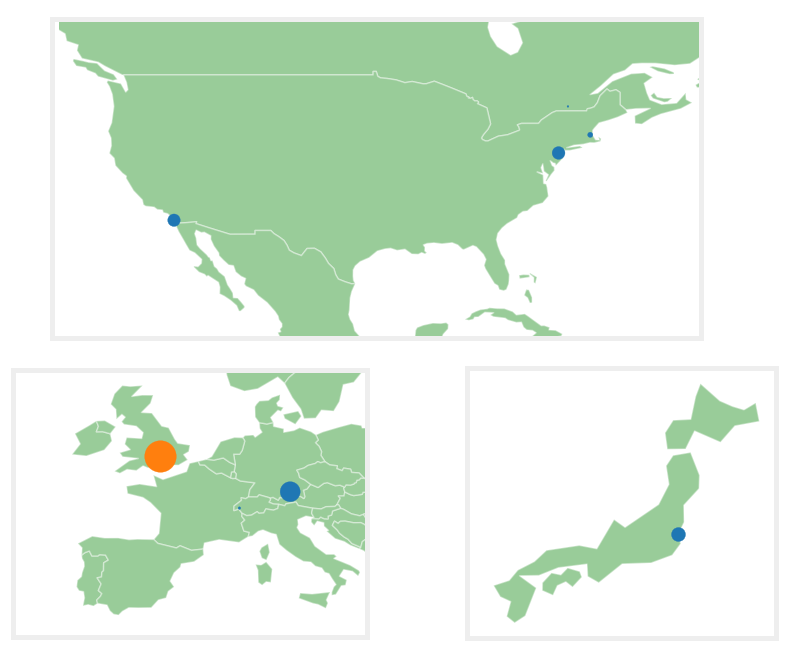

In [700]:
fig3 = plt.figure(constrained_layout=True, figsize=(12,9))
gs = fig3.add_gridspec(11, 7)
f3_ax1 = fig3.add_subplot(gs[:6, :])
f3_ax2 = fig3.add_subplot(gs[6:, :-3])
f3_ax3 = fig3.add_subplot(gs[6:, -3:])

bar("america", False, f3_ax1)
bar("europe", False, f3_ax2)
plt.ylabel(" ")
bar("japan", False, f3_ax3)
f3_ax3.yaxis.set_label_position("right")
plt.ylabel(" ");


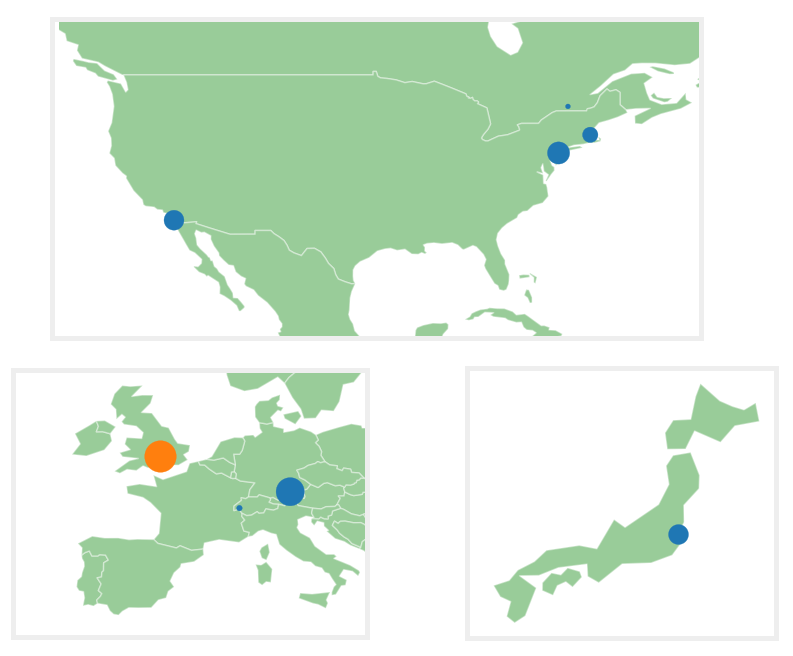

In [701]:
fig3 = plt.figure(constrained_layout=True, figsize=(12,9))
gs = fig3.add_gridspec(11, 7)
f3_ax1 = fig3.add_subplot(gs[:6, :])
f3_ax2 = fig3.add_subplot(gs[6:, :-3])
f3_ax3 = fig3.add_subplot(gs[6:, -3:])

bar("america", True, f3_ax1)
bar("europe", True, f3_ax2)
plt.ylabel(" ")
bar("japan", True, f3_ax3)
f3_ax3.yaxis.set_label_position("right")
plt.ylabel(" ");


In [699]:
def bar(cur_key, use_tar, ax):
    points = gdf[(gdf.continent == cur_key) & (gdf.jet != 1)]
    op = gdf[(gdf.continent == cur_key) & (gdf.jet == 1)]
    db, ylim, xlim = dd[cur_key]
    
    cur_col = "tar" if use_tar else "all"
    
    mm = 1000
    
    ss = np.array(list((points[cur_col].values)))
    ss = ss / np.max(gdf[cur_col]) * mm
    
    ss1 = np.array(list((op[cur_col].values)))
    ss1 = ss1 / np.max(gdf[cur_col]) * mm

    db.plot(ax=ax,color="green", edgecolor="white", alpha=0.4, linewidth=1.5, facecolor="none")
    ax.scatter(list(points.geometry.x), list(points.geometry.y), s=ss)
    ax.scatter(list(op.geometry.x), list(op.geometry.y), s=ss1)

    if xlim != None and ylim != None:
        ax.axis(
            xmin=xlim[0],xmax=xlim[-1],
            ymin=ylim[0],ymax=ylim[-1]
        )
        
    ax.set_aspect('equal')
#     ax.facecolor("lightslategray")
    ax.set_facecolor("white")
#     ax.axis('off')
    
    plt.sca(ax)
    plt.title(" ")
    plt.xlabel(" ")
    plt.xticks((), ())
    plt.yticks((), ())
    
    autoAxis = ax.axis()
    rec = Rectangle((autoAxis[0]-0.8,autoAxis[2]-0.2),(autoAxis[1]-autoAxis[0])+1,(autoAxis[3]-autoAxis[2])+0.4,fill=False,lw=5)
    rec = ax.add_patch(rec)
    rec.set_clip_on(False)
    

In [696]:
def foo(cur_key, use_tar):
    bar(cur_key, use_tar, plt.axes());
    
interact(foo, cur_key=widgets.Select(options=dd.keys()), use_tar=True);


interactive(children=(Select(description='cur_key', options=('europe', 'america', 'japan'), value='europe'), C…

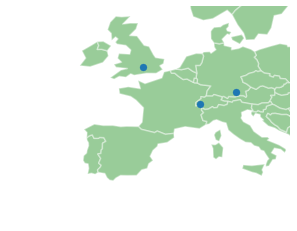

In [657]:
ax = europa.plot(color="green", edgecolor="white", alpha=0.4, linewidth=1.5, facecolor="none")
plt.ylim(30,60)
plt.xlim(-20,19)
ax.grid(False)

plt.axis('off')
gdf[gdf.continent == "europe"].plot(ax=ax)
ax.set_aspect('equal')
# plt.grid(b=None)

(-130.0, -59.0, 20.0, 55.0)

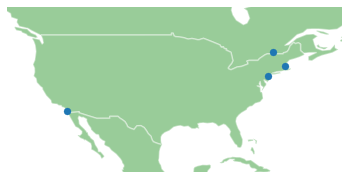

In [278]:
ax = americas.plot(color="green", edgecolor="white", alpha=0.4, linewidth=1.5, facecolor="none")

ax.grid(False)

gdf[gdf.continent == "america"].plot(ax=ax)
ax.set_aspect('equal')
plt.axis('off')


In [288]:
gdf[gdf.continent == "japan"]["all"]

Naka    619
Name: all, dtype: object

In [292]:
gdf[gdf.continent == "japan"].geometry.x

Naka    140.595861
dtype: float64

In [301]:
plt.scatter(points.geometry.x, points.geometry.y, s=points["all"]) gdf[gdf.continent == "japan"].geometry.x

Naka    140.595861
dtype: float64

In [326]:
points.geometry.x

Naka    140.595861
dtype: float64

In [342]:
np.max(gdf["all"])

3144

(128.60172946585604, 146.3498709454192, 30.303483954381587, 46.27757868100799)

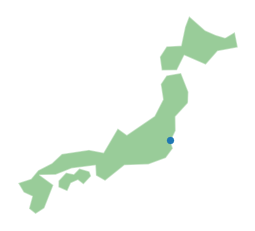

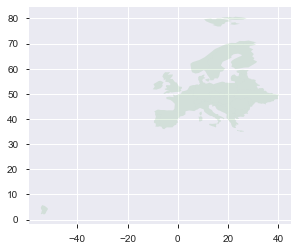

In [73]:
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [ ]:
pnts.within(geom)

In [47]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


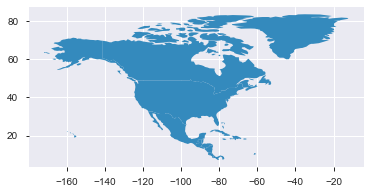

(-66.66666666666666, 100)

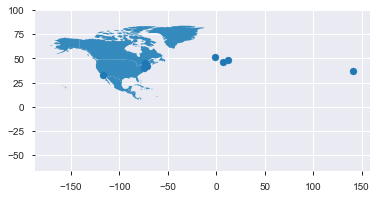

In [71]:

ax = world[world.continent == "North America"].plot()
gdf.plot(ax=ax)
plt.ylim(-2/3*100,100)


In [4]:
for cur_key, cur_value in map_dict.items():
    print(cur_key)
    

"JET"
"Max Planck"
"MIT"
"San Diego"
"Naka"
"Switzerland"
"Montreal"
"PPPL"
